# Overview

In this notebook, we will apply the similar images verified in this [NOTEBOOK](https://www.kaggle.com/showeed/annoy-similar-images-edit2)   
to make predictions based on the labels (Pawpularity) of similar images.

This is by no means the only way to do a good analysis,   
but in my case, ensembling it with the predictions of swin_transformer gave me good results.

# Image
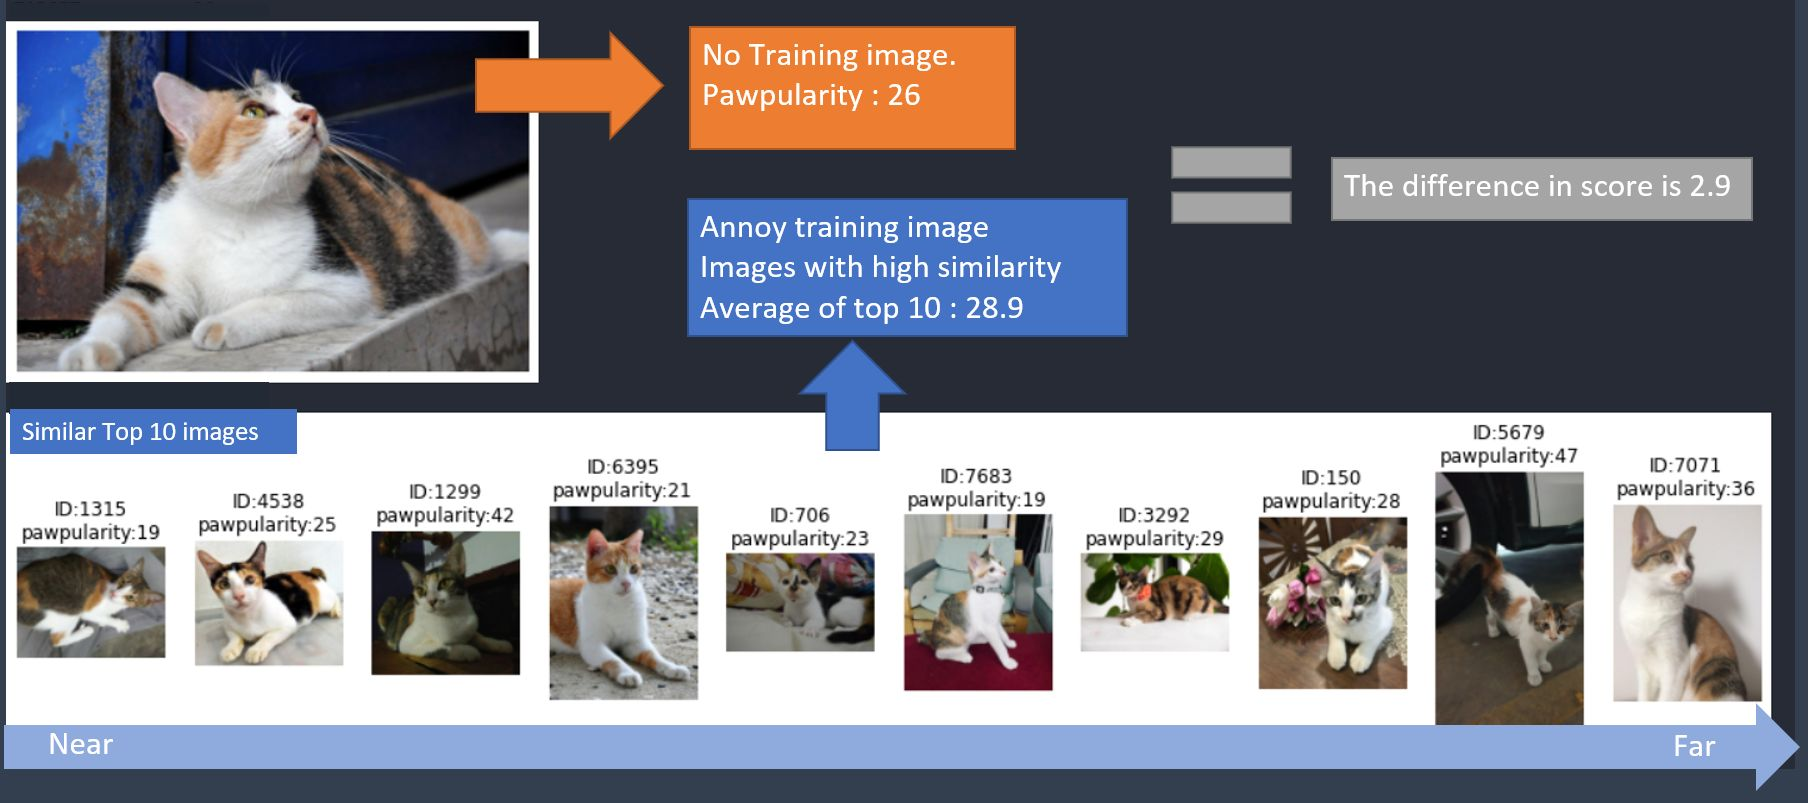

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
#TF
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential,Model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Dropout, Input, Concatenate, BatchNormalization
#other
from tqdm.notebook import tqdm
import pickle
from PIL import Image
from annoy import AnnoyIndex
from sklearn.model_selection import train_test_split, KFold, cross_validate, StratifiedKFold
from sklearn.metrics import mean_squared_error

# Set Petfinder Dataset

In [ ]:
# dataset
train_dir = "/kaggle/input/petfinder-pawpularity-score/train/"
test_dir = "/kaggle/input/petfinder-pawpularity-score/test/"
train_table = pd.read_csv("/kaggle/input/petfinder-pawpularity-score/train.csv")
test_table = pd.read_csv("/kaggle/input/petfinder-pawpularity-score/test.csv")

# set path
train_table["Id"] = train_dir + train_table["Id"] + ".jpg"
test_table["Id"] = test_dir + test_table["Id"] + ".jpg"

# stratify label
train_table['stratify_label'] = pd.qcut(train_table['Pawpularity'], q=30, labels=range(30))

sample = pd.read_csv("/kaggle/input/petfinder-pawpularity-score/sample_submission.csv")
train_table.head()

# Set function

In [ ]:
def MobileNet_model():
    base_model = keras.applications.mobilenet_v2.MobileNetV2(weights=None)
    base_model.load_weights("../input/mobilenetv2-imagenet/MobileNetV2_imagenet.h5")
    avg_pool_name = [l.name for l in base_model.layers][-2]
    x = base_model.get_layer(avg_pool_name).output
    model = Model(inputs=base_model.input, outputs=x)
    return model

def img_yield(pathes, batch_size=32, size=(224,224)):
    for i in tqdm(range(int(np.ceil(len(pathes) / batch_size)))):
        imgs = []
        batch_pathes = pathes[i*batch_size : (1+i)*batch_size]
        if len(batch_pathes)==0: break
        for path in batch_pathes:
            img = load_img(path, target_size=size)
            img = tf.keras.applications.mobilenet_v2.preprocess_input(np.array(img))
            imgs.append(img)
        yield np.array(imgs)
        
def show_img(df, ids):
    imgs = [Image.open(df["Id"][i]) for i in ids]
    pawpularity = [df["Pawpularity"][i] for i in ids]
    fig, axes = plt.subplots(1, 10, figsize=(20,8))
    for i, ax in zip(range(10), axes.ravel()):
        ax.set_title(i+1)
        ax.imshow(imgs[i])
        if i == 0:
            ax.set_title(f"ID:{ids[i]}\npawpularity:{pawpularity[i]}")
        else:
            ax.set_title(f"ID:{ids[i]}\npawpularity:{pawpularity[i]}")
        ax.axis("off")
    plt.show()
    
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) * 100

def softmax(arr):
    a = np.exp(arr)
    b = np.sum(a)
    return a / b

# Assign a score according to the distance between the target and the similar image
def soft_pred(ids, distance, y):
    dis = 1-np.array(distance)
    dis = softmax(dis)
    pred = sum(dis * np.array(y[ids]))
    return pred

In [ ]:
class ANNOY_ANALYSIS:
    def __init__(self, train_df, test_df, meta=False):
        self.train_df = train_df.reset_index(drop=True)
        self.test_df = test_df.reset_index(drop=True)
        meta_columns = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory','Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']
        self.train_meta = self.train_df.loc[:, meta_columns]
        self.test_meta = self.test_df.loc[:, meta_columns]
        self.meta_flag = meta
        self.embed_model = MobileNet_model()
        self.y_train = train_df["Pawpularity"].values
        self.train_embed = self._embed(train_df["Id"].values)  
        self.test_embed = self._embed(test_df["Id"].values)  
        self.annoy_model = self._build_annoy()
        
    def test_predcit(self, N=5):
        preds, id_list = [], []
        if self.meta_flag:
            inputs = np.hstack([self.test_embed, self.test_meta])
            for embed in tqdm(inputs):
                ids, distance = self.annoy_model.get_nns_by_vector(embed, N, include_distances=True)
                preds.append(soft_pred(ids, distance, self.y_train))
                id_list.append(ids)
        else:
            for embed in tqdm(self.test_embed):
                ids, distance = self.annoy_model.get_nns_by_vector(embed, N, include_distances=True)
                preds.append(soft_pred(ids, distance, self.y_train))
                id_list.append(ids)
        self.preds = np.array(preds)
        self.id_list = id_list
        return self.preds, id_list
    
    def compere_image(self, target_id, i):
        print("*"*30, f"sample_{i+1}", "*"*30)
        print("TARGET  score :", self.test_df["Pawpularity"][target_id])
        img = Image.open(self.test_df["Id"][target_id])
        plt.imshow(img)
        plt.axis("off")
        plt.show()
        print(f"Annoy_predict : {self.preds[target_id]:.1f}")
        near_img_id = self.id_list[target_id]
        show_img(self.train_df, self.id_list[target_id])
        
    def max_sample(self, N=3):
        ids = np.argsort(self.preds)[::-1][:10]
        rnd = np.random.choice(ids, size=N, replace=False)
        for i, r in enumerate(rnd):
            self.compere_image(r, i)
            
    def min_sample(self, N=3):
        ids = np.argsort(self.preds)[:10]
        rnd = np.random.choice(ids, size=N, replace=False)
        for i, r in enumerate(rnd):
            self.compere_image(r, i)
                       
    def _embed(self, pathes):
        return self.embed_model.predict(img_yield(pathes))
    
    def _build_annoy(self):
        if self.meta_flag:
            inputs = np.hstack([self.train_embed, self.train_meta])
            annoy_model = AnnoyIndex(inputs.shape[1])
            for i, embed in enumerate(inputs):
                annoy_model.add_item(i, embed)
            annoy_model.build(i)
            return annoy_model
        else:
            annoy_model = AnnoyIndex(self.train_embed.shape[1])
            for i, embed in enumerate(self.train_embed):
                annoy_model.add_item(i, embed)
            annoy_model.build(i)
            return annoy_model

# validation

In [ ]:
train_df, test_df = train_test_split(train_table, train_size=0.9, stratify=train_table["stratify_label"], random_state=2021)
AA = ANNOY_ANALYSIS(train_df, test_df, meta=True)

In [ ]:
y_test = test_df["Pawpularity"].values
for N in range(10, 51, 10):
    preds, ids = AA.test_predcit(N)
    print(f"N={N}  RMSE : {RMSE(y_test, preds) / 100:.4f}   SCORE_MEAN : {np.mean(preds):.4f}")

## Check Maximum predict image

In [ ]:
AA.max_sample()

## Check Minimum predict image

In [ ]:
AA.min_sample()

# Submit process

In [ ]:
# dataset
train_dir = "/kaggle/input/petfinder-pawpularity-score/train/"
test_dir = "/kaggle/input/petfinder-pawpularity-score/test/"
train_table = pd.read_csv("/kaggle/input/petfinder-pawpularity-score/train.csv")
test_table = pd.read_csv("/kaggle/input/petfinder-pawpularity-score/test.csv")

# set path
train_table["Id"] = train_dir + train_table["Id"] + ".jpg"
test_table["Id"] = test_dir + test_table["Id"] + ".jpg"

train_table.head()

In [ ]:
AA = ANNOY_ANALYSIS(train_table, test_table, meta=True)
final_pred, _ = AA.test_predcit(20)

In [ ]:
id_tmp = pd.read_csv("/kaggle/input/petfinder-pawpularity-score/test.csv")
sub = pd.DataFrame()
sub['Id'] = id_tmp['Id']
sub['Pawpularity'] = final_pred
sub.to_csv("submission.csv", index = False)
sub